## Import libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from pmdarima import auto_arima
from pickle import dump

## Import data

In [30]:
total_data= pd.read_csv("../data/raw/crime_query.csv")
total_data.head()

,date_occ,time_occ,area_name,rpt_dist_no,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_desc,weapon_desc,status_desc,location,lat,lon
0,2020-01-08T00:00:00.000,2230,Southwest,377,BATTERY - SIMPLE ASSAULT,0444 0913,36,F,B,SINGLE FAMILY DWELLING,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,1100 W 39TH PL,34.0141,-118.2978
1,2020-01-01T00:00:00.000,330,Central,163,BATTERY - SIMPLE ASSAULT,0416 1822 1414,25,M,H,SIDEWALK,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S HILL ST,34.0459,-118.2545
2,2020-02-13T00:00:00.000,1200,Central,155,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,1501,0,X,X,POLICE FACILITY,NaN,Adult Arrest,200 E 6TH ST,34.0448,-118.2474
3,2020-01-01T00:00:00.000,1730,N Hollywood,1543,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329 1402,76,F,W,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Invest Cont,5400 CORTEEN PL,34.1685,-118.4019
4,2020-01-01T00:00:00.000,415,Mission,1998,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,31,X,X,BEAUTY SUPPLY STORE,NaN,Invest Cont,14400 TITUS ST,34.2198,-118.4468


In [31]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606984 entries, 0 to 606983
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date_occ      606984 non-null  object 
 1   time_occ      606984 non-null  int64  
 2   area_name     606984 non-null  object 
 3   rpt_dist_no   606984 non-null  int64  
 4   crm_cd_desc   606984 non-null  object 
 5   mocodes       522665 non-null  object 
 6   vict_age      606984 non-null  int64  
 7   vict_sex      526671 non-null  object 
 8   vict_descent  526664 non-null  object 
 9   premis_desc   606516 non-null  object 
 10  weapon_desc   212782 non-null  object 
 11  status_desc   606984 non-null  object 
 12  location      606984 non-null  object 
 13  lat           606984 non-null  float64
 14  lon           606984 non-null  float64
dtypes: float64(2), int64(3), object(10)
memory usage: 69.5+ MB


In [32]:
# turn format date into %Y/%m/%d
total_data["date_occ"] = pd.to_datetime(total_data["date_occ"]).dt.date

In [33]:
total_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606984 entries, 0 to 606983
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   date_occ      606984 non-null  object 
 1   time_occ      606984 non-null  int64  
 2   area_name     606984 non-null  object 
 3   rpt_dist_no   606984 non-null  int64  
 4   crm_cd_desc   606984 non-null  object 
 5   mocodes       522665 non-null  object 
 6   vict_age      606984 non-null  int64  
 7   vict_sex      526671 non-null  object 
 8   vict_descent  526664 non-null  object 
 9   premis_desc   606516 non-null  object 
 10  weapon_desc   212782 non-null  object 
 11  status_desc   606984 non-null  object 
 12  location      606984 non-null  object 
 13  lat           606984 non-null  float64
 14  lon           606984 non-null  float64
dtypes: float64(2), int64(3), object(10)
memory usage: 69.5+ MB


In [34]:
# Count the occurrences of each crime type per day
daily_crime_counts = total_data.groupby(['date_occ', 'crm_cd_desc']).size().reset_index(name='count')

# Calculate the total number of crimes per day
daily_total_crimes = total_data.groupby('date_occ').size().reset_index(name='total_crimes')

# Merge the two DataFrames to have the count of each crime type and the total crimes per day
daily_crime_counts = pd.merge(daily_crime_counts, daily_total_crimes, on='date_occ')

# Calculate the percentage of crime for each crime type
daily_crime_counts['crime_percentage'] = (daily_crime_counts['count'] / daily_crime_counts['total_crimes']) * 100

# Merge DataFrame with original DataFrame
total_data = pd.merge(total_data, daily_crime_counts[['date_occ', 'crm_cd_desc', 'crime_percentage']], on=['date_occ', 'crm_cd_desc'], how='left')

total_data.head()

,date_occ,time_occ,area_name,rpt_dist_no,crm_cd_desc,mocodes,vict_age,vict_sex,vict_descent,premis_desc,weapon_desc,status_desc,location,lat,lon,crime_percentage
0,2020-01-08,2230,Southwest,377,BATTERY - SIMPLE ASSAULT,0444 0913,36,F,B,SINGLE FAMILY DWELLING,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",Adult Other,1100 W 39TH PL,34.0141,-118.2978,14.400000
1,2020-01-01,330,Central,163,BATTERY - SIMPLE ASSAULT,0416 1822 1414,25,M,H,SIDEWALK,UNKNOWN WEAPON/OTHER WEAPON,Invest Cont,700 S HILL ST,34.0459,-118.2545,8.121827
2,2020-02-13,1200,Central,155,SEX OFFENDER REGISTRANT OUT OF COMPLIANCE,1501,0,X,X,POLICE FACILITY,NaN,Adult Arrest,200 E 6TH ST,34.0448,-118.2474,1.197605
3,2020-01-01,1730,N Hollywood,1543,VANDALISM - MISDEAMEANOR ($399 OR UNDER),0329 1402,76,F,W,"MULTI-UNIT DWELLING (APARTMENT, DUPLEX, ETC)",NaN,Invest Cont,5400 CORTEEN PL,34.1685,-118.4019,7.106599
4,2020-01-01,415,Mission,1998,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,31,X,X,BEAUTY SUPPLY STORE,NaN,Invest Cont,14400 TITUS ST,34.2198,-118.4468,4.568528


In [35]:
total_data.columns

Index(['date_occ', 'time_occ', 'area_name', 'rpt_dist_no', 'crm_cd_desc',
       'mocodes', 'vict_age', 'vict_sex', 'vict_descent', 'premis_desc',
       'weapon_desc', 'status_desc', 'location', 'lat', 'lon',
       'crime_percentage'],
      dtype='object')

In [36]:
# Get the frequency count of top 20 crimes 
delitos=total_data.value_counts("crm_cd_desc")[0:20]
delitos=pd.DataFrame(delitos)
delitos.head()

,count
crm_cd_desc,
VEHICLE - STOLEN,64078
BATTERY - SIMPLE ASSAULT,50566
BURGLARY FROM VEHICLE,37595
"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)",36906
BURGLARY,36599


In [37]:
# Taking only crime type Vehicle - Stolen
vehicle_data = total_data[["date_occ", "crime_percentage"]].loc[total_data["crm_cd_desc"] == "VEHICLE - STOLEN"]
vehicle_data

,date_occ,crime_percentage
22,2020-09-03,10.400000
57,2020-01-02,9.923664
104,2020-02-06,13.138686
125,2020-01-04,6.766917
137,2020-01-06,6.081081
...,...,...
606930,2023-08-30,12.014787
606946,2023-04-20,8.534323
606957,2023-03-19,11.356467
606959,2023-04-29,10.380952


In [38]:
# Sort dates
vehicle_data = vehicle_data.sort_values(by='date_occ')
vehicle_data

,date_occ,crime_percentage
1317,2020-01-01,5.076142
13348,2020-01-01,5.076142
6160,2020-01-01,5.076142
3009,2020-01-01,5.076142
3005,2020-01-01,5.076142
...,...,...
358223,2023-12-31,10.237069
347336,2023-12-31,10.237069
536340,2023-12-31,10.237069
311858,2023-12-31,10.237069


In [39]:
# Count duplicate rows
duplicate_count = vehicle_data.duplicated().sum()
duplicate_count

62617

In [40]:
# Remove duplicate rows
vehicle_data.drop_duplicates(inplace= True)
vehicle_data.shape

(1461, 2)

In [41]:
vehicle_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1461 entries, 1317 to 454622
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date_occ          1461 non-null   object 
 1   crime_percentage  1461 non-null   float64
dtypes: float64(1), object(1)
memory usage: 34.2+ KB


In [42]:
# Turn date column into index
vehicle_data.set_index("date_occ", inplace=True)
vehicle_data.head()

,crime_percentage
date_occ,
2020-01-01,5.076142
2020-01-02,9.923664
2020-01-03,6.122449
2020-01-04,6.766917
2020-01-05,6.716418


In [43]:
# Turn into a serie 
ts = vehicle_data["crime_percentage"]
ts

date_occ
2020-01-01     5.076142
2020-01-02     9.923664
2020-01-03     6.122449
2020-01-04     6.766917
2020-01-05     6.716418
                ...    
2023-12-27    13.585291
2023-12-28    15.018315
2023-12-29    14.420063
2023-12-30    12.461059
2023-12-31    10.237069
Name: crime_percentage, Length: 1461, dtype: float64

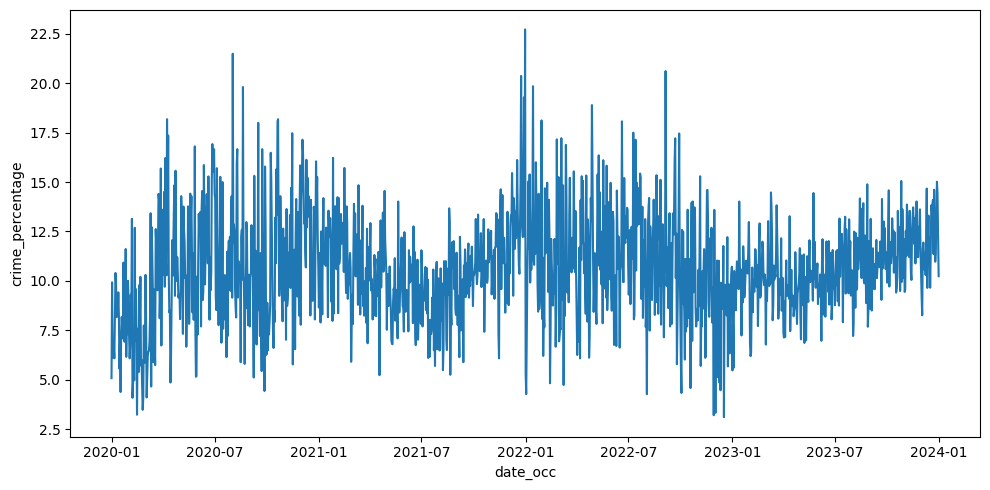

In [44]:
# Plot sales

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)

plt.tight_layout()

plt.show()

## Decomposition of the serie

In [45]:
decomposition = seasonal_decompose(ts, period = 12)
decomposition

## Trend analysis

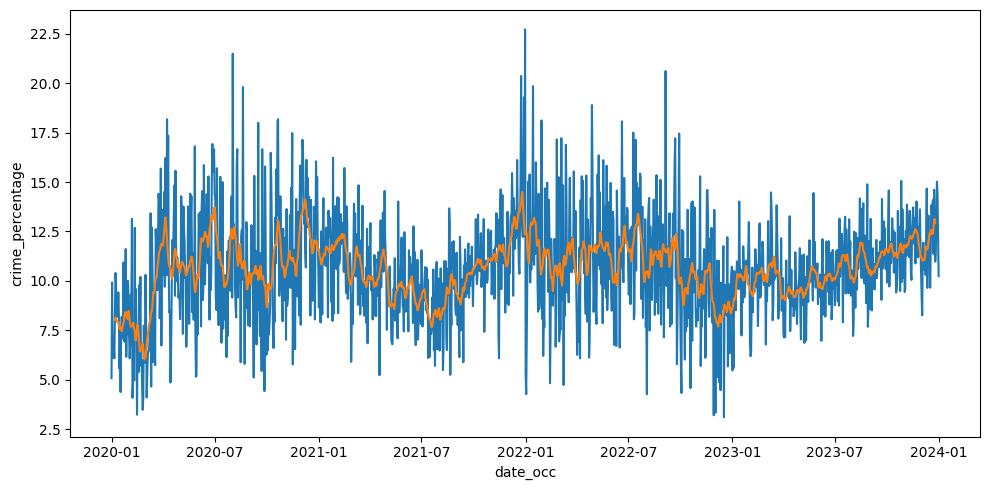

In [46]:
trend = decomposition.trend

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = trend)

plt.tight_layout()

plt.show()

## Seasonality analysis

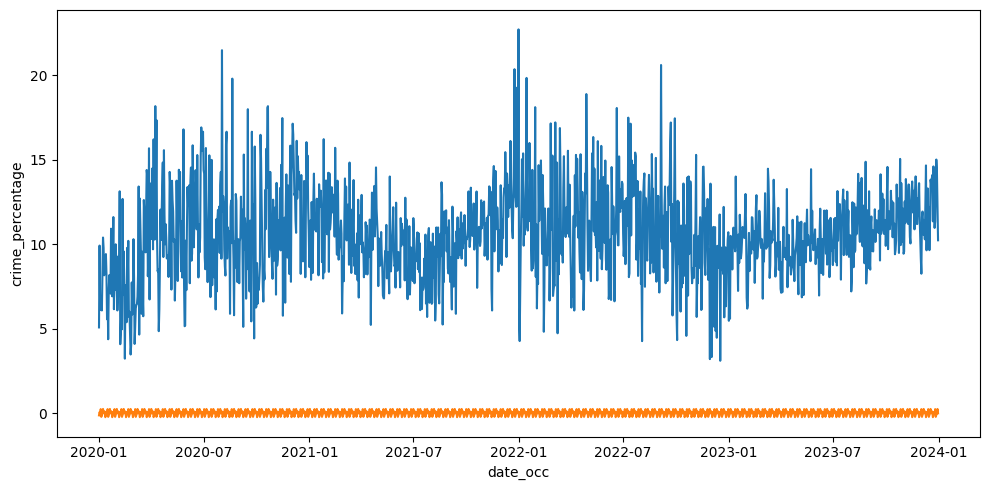

In [47]:
seasonal = decomposition.seasonal

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = seasonal)

plt.tight_layout()

plt.show()

## Dickey-Fuller test

Null Hypothesis (H0): the series is non-stationary

Alternative Hypothesis (H1): the series is stationary

In [48]:
def test_stationarity(timeseries):
    print("Resultados de la prueba de Dickey-Fuller:")
    dftest = adfuller(timeseries, autolag = "AIC")
    dfoutput = pd.Series(dftest[0:4], index = ["Test Statistic", "p-value", "#Lags Used", "Number of Observations Used"])
    for key,value in dftest[4].items():
        dfoutput["Critical Value (%s)"%key] = value
    return dfoutput

test_stationarity(ts)

Resultados de la prueba de Dickey-Fuller:


Test Statistic                   -4.868940
p-value                           0.000040
#Lags Used                       15.000000
Number of Observations Used    1445.000000
Critical Value (1%)              -3.434884
Critical Value (5%)              -2.863542
Critical Value (10%)             -2.567836
dtype: float64

## Analysis of variability

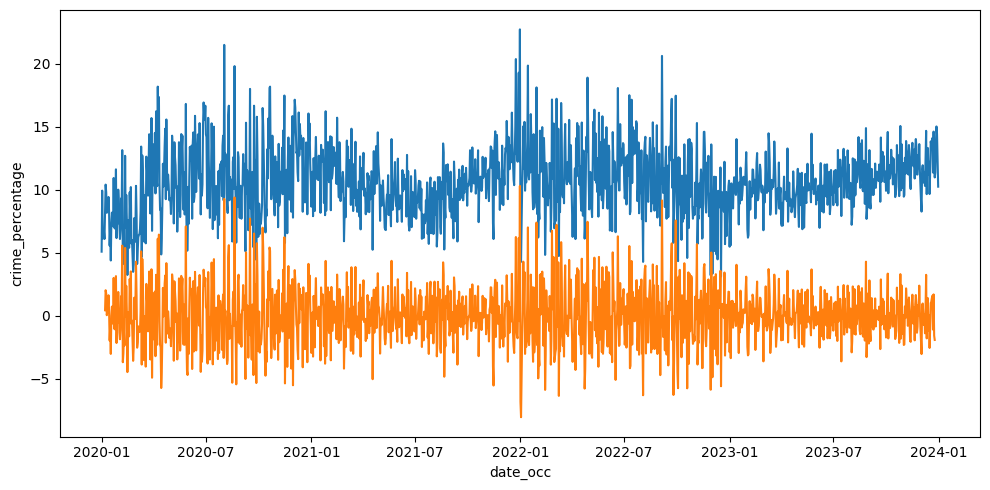

In [49]:
residual = decomposition.resid

fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = residual)

plt.tight_layout()

plt.show()

## Autocorrelation analysis

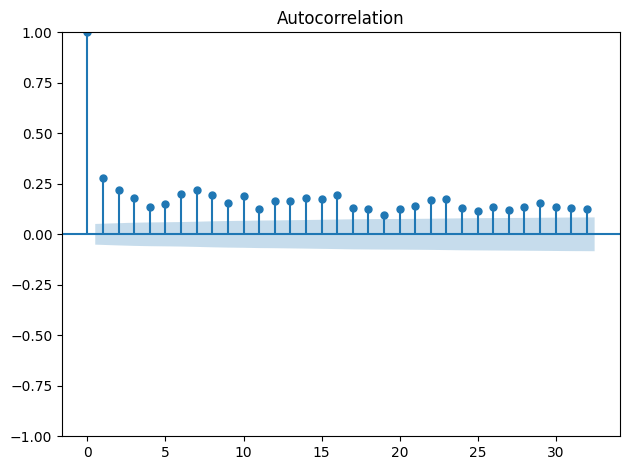

In [50]:
plot_acf(ts)

plt.tight_layout()

plt.show()

## ARIMA Model

In [51]:
# Create model stationary

model = auto_arima(ts, seasonal = True, trace = True, m = 12)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=6769.959, Time=2.95 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=7535.517, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=7193.903, Time=0.61 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=6780.348, Time=0.95 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=7533.519, Time=0.05 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=6767.957, Time=2.16 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=6765.966, Time=0.76 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=6767.957, Time=2.11 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=6765.645, Time=1.62 sec
 ARIMA(1,1,2)(1,0,0)[12] intercept   : AIC=6767.577, Time=3.71 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AIC=6767.575, Time=3.86 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=6769.592, Time=4.90 sec
 ARIMA(0,1,2)(0,0,0)[12] intercept   : AIC=6765.832, Time=0.50 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=6764.659, Time=0.54 sec
 ARIMA(1,1,1)(1,0,0

In [52]:
# Displaying model summary
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1461
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -3378.643
Date:                Sun, 04 Feb 2024   AIC                           6763.285
Time:                        21:05:08   BIC                           6779.144
Sample:                    01-01-2020   HQIC                          6769.201
                         - 12-31-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1115      0.023      4.802      0.000       0.066       0.157
ma.L1         -0.9440      0.008   -124.879      0.000      -0.959      -0.929
sigma2         5.9835      0.183     32.643      0.000       5.624       6.343
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                63.87
Prob(Q):                              0.89   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.23
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [53]:
# Predict 30 days of sales
forecast = model.predict(15)
forecast

2024-01-01    12.047712
2024-01-02    12.249512
2024-01-03    12.272003
2024-01-04    12.274509
2024-01-05    12.274789
2024-01-06    12.274820
2024-01-07    12.274823
2024-01-08    12.274824
2024-01-09    12.274824
2024-01-10    12.274824
2024-01-11    12.274824
2024-01-12    12.274824
2024-01-13    12.274824
2024-01-14    12.274824
2024-01-15    12.274824
Freq: D, dtype: float64

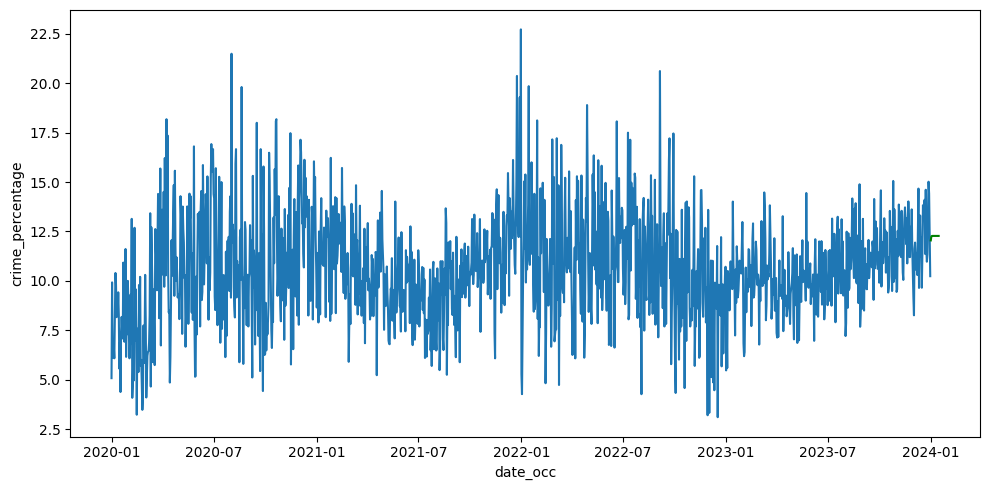

In [54]:
# Plot sales with prediction
fig, axis = plt.subplots(figsize = (10, 5))

sns.lineplot(data = ts)
sns.lineplot(data = forecast, c = "green")

plt.tight_layout()

plt.show()